# Survey Validation Data Challenge - Summer 2018

### Notebook 1 -- Generate a BGS/GAMA Parent Sample

The purpose of this notebook is to generate a BGS-like sample from existing GAMA observations.  We use GAMA targets and field centers, GAMA/SDSS spectroscopic redshifts, and Legacy Surveys photometry.

* Run on 18.12

* Currently missing kcorrection files for GAMA sample. Cell 41 kcorr file, cell 51 for associated QA.

In [1]:
import os, time, warnings
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import fitsio
from astropy.table import Table, Column
from desispec.io.util import write_bintable

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Fri May 10 09:12:14 2019


#### Specify whether the output catalog should be overwritten.

If *overwrite_sample=True* all the output files and plots will be recreated.

In [6]:
overwrite_sample = True

### Define the top-level base (output) directory

We assume that *basedir* already has the appropriate GAMA catalogs downloaded.  See `${DESI_ROOT}/datachallenge/svdc-summer2018/GAMA-DR3/README` for details.

In [24]:
basedir    = os.path.join(os.getenv('SCRATCH'), 'svdc-summer2018')
gamadir    = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018', 'GAMA-DR3')

samplefile = os.path.join(basedir, 'bgs-gama-sample.fits')

### Read the parent GAMA catalogs.

We use [SpecObj](http://www.gama-survey.org/dr3/schema/table.php?id=31) from GAMA/DR3 as the baseline parent catalog and use the measured emission-line fluxes and equivalent widths from the [GaussFitSimple](http://www.gama-survey.org/dr3/schema/table.php?id=40) catalog.

We also assign field names (G02, G09, G12, G15, and G23) to all targets based on simple RA, Dec cuts (see [Liske et al. 2015](https://arxiv.org/abs/1506.08222) and [Baldry et al. 2017](https://arxiv.org/abs/1711.09139)).  

Finally, note that we divide the G02 field into G02_ALL ("all" targets") and the spectroscopically complete portion, G02 (bounded by -6<Dec<4).

In [13]:
print(basedir)
print(gamadir)
print(samplefile)

/global/cscratch1/sd/mjwilson/svdc-summer2018
/global/project/projectdirs/desi/datachallenge/svdc-summer2018/GAMA-DR3
/global/cscratch1/sd/mjwilson/svdc-summer2018/bgs-gama-sample.fits


In [58]:
def get_absmag(gama, H0=70, Om0=0.3):
    """
    Compute absolute magnitudes from the SDSS photometry and 
    pre-computed K-corrections.
    
    **This function is deprecated as we compute K-corrections ourselves.**
    
    """
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # New columns
    for band in ('U', 'G', 'R', 'I', 'Z'):
        gama.add_column(Column(name='MABS_{}'.format(band), dtype='f4', length=len(gama)))

    # Require good, positive redshifts, good photometry, and good K-corrections
    good = ~gama['Z'].mask * (ma.getdata(gama['Z']) > 0)
    
    for band in ('U', 'G', 'R','I', 'Z'):
        good *= ~gama['MODELMAG_{}'.format(band)].mask
        good *= ~gama['KCORR_{}'.format(band)].mask
    
    gama = gama[good]
    
    print('Computing absolute magnitudes for {} objects with z>0 and good photometry.'.format(len(gama)))

    DM = cosmo.distmod(gama['Z'].data).value

    for band in ('U', 'G', 'R', 'I', 'Z'):
        kcorr = ma.getdata(gama['KCORR_{}'.format(band)])
        mag = ma.getdata(gama['MODELMAG_{}'.format(band)])
        gama['MABS_{}'.format(band)] = mag - kcorr - DM
        
    # Clean up a bit...
    gama.remove_columns(['KCORR_U', 'KCORR_G', 'KCORR_R', 'KCORR_I', 'KCORR_Z'])

    return gama

In [59]:
def read_all_gama(overwrite=False):
    """
    Read all the GAMA/DR3 catalogs.
    """
    from astropy.table import join
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Spectroscopic redshifts
        specobjfile = os.path.join(gamadir, 'SpecObj.fits')
        specobj = Table.read(specobjfile)
        
        print('Read {} objects from {}'.format(len(specobj), specobjfile))    
    
        #photfile = os.path.join(gamadir, 'InputCatA.fits')
        #phot = Table(fitsio.read(photfile, columns=['CATAID', 'OBJID', 'TYPE', 'PSFMAG_R', 'FIBERMAG_R', 
        #                                            'PETRORAD_R', 'MODELMAG_U', 'MODELMAG_G', 
        #                                            'MODELMAG_R', 'MODELMAG_I', 'MODELMAG_Z'], ext=1))
        #print('Read {} objects from {}'.format(len(phot), photfile))
    
        #kcorrfile = os.path.join(gamadir, 'kcorr_model_z01.fits')
        #kcorr = Table(fitsio.read(kcorrfile, columns=['CATAID', 'KCORR_U', 'KCORR_G', 
        #                                              'KCORR_R', 'KCORR_I', 'KCORR_Z'], ext=1))
        #print('Read {} objects from {}'.format(len(kcorr), kcorrfile))
        
        # Emission lines
        gaussfitfile = os.path.join(gamadir, 'GaussFitSimple.fits')
        gg = fitsio.FITS(gaussfitfile)
        these = gg[1].where('is_best')
        gaussfit = Table(gg[1][these])
        gaussfit = gaussfit[['CATAID', 'D4000N', 'HB_EW', 'HA_EW']]
        print('Read {} (unique) objects from {}'.format(len(gaussfit), gaussfitfile))

        # Join all the catalogs
        #gama = join(specobj, kcorr, join_type='left', keys='CATAID')
        #gama = join(gama, phot, join_type='left', keys='CATAID')
        gama = join(specobj, gaussfit, join_type='left', keys='CATAID')
        
        # Compute absolute magnitudes
        # gama = get_absmag(gama)
                
        # Add field names -- see Table 1 in Liske et al. 2015
        gama.add_column(Column(name='FIELD', dtype='U9', length=len(gama)))

        g02 = ( (gama['RA'] >= 30.2) * (gama['RA'] <= 38.8) * 
               (gama['DEC'] >= -6.0) * (gama['DEC'] <= -4) )
        g02_other = ( (gama['RA'] >= 30.2) * (gama['RA'] <= 38.8) * 
               (gama['DEC'] >= -10.25) * (gama['DEC'] <= -3.72) )
        g09 = ( (gama['RA'] >= 129) * (gama['RA'] <= 141) * 
               (gama['DEC'] >= -2) * (gama['DEC'] <= 3) )
        g12 = ( (gama['RA'] >= 174) * (gama['RA'] <= 186) * 
               (gama['DEC'] >= -3) * (gama['DEC'] <= 2) )
        g15 = ( (gama['RA'] >= 211.5) * (gama['RA'] <= 223.5) * 
               (gama['DEC'] >= -2) * (gama['DEC'] <= 3) )
        #g23 = ( (gama['RA'] >= 339) * (gama['RA'] <= 351) * 
        #       (gama['DEC'] >= -35) * (gama['DEC'] <= -30) )
        
        gama['FIELD'] = 'NONE'
        gama['FIELD'][g02_other] = 'G02_OTHER'
        gama['FIELD'][g02] = 'G02'
        gama['FIELD'][g09] = 'G09'
        gama['FIELD'][g12] = 'G12'
        gama['FIELD'][g15] = 'G15'
        #gama['FIELD'][g23] = 'G23'

        if overwrite:
            gamafile = os.path.join(basedir, 'gama-dr3.fits')
            print('Writing {} objects to {}'.format(len(gama), gamafile))
            #gama.write(gamafile, overwrite=overwrite)
            write_bintable(gamafile, gama, clobber=overwrite, extname='GAMA-DR3')
                
    return gama

In [57]:
allgama = read_all_gama(overwrite=overwrite_sample)
allgama

Read 160026 objects from /global/project/projectdirs/desi/datachallenge/svdc-summer2018/GAMA-DR3/SpecObj.fits
Read 155117 (unique) objects from /global/project/projectdirs/desi/datachallenge/svdc-summer2018/GAMA-DR3/GaussFitSimple.fits
Writing 160026 objects to /global/cscratch1/sd/mjwilson/svdc-summer2018/gama-dr3.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA,DEC,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,D4000N,HB_EW,HA_EW,FIELD
,,,,,arcsec,,,,deg,deg,A,A,,,,,,,,,,
int32,str23,int16,int16,int16,float32,str33,str9,int16,float64,float64,float32,float64,float32,int16,float32,str67,str88,str92,float32,float32,float32,str9
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,1.81131,5.20334,27.8028,G12
6806,GAMAJ113605.47+004221.3,4104,1,1,0.07,G12_Y1_AN1_238,GAMA,5,174.02279,0.70594,3727.79,8856.73,0.33124,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_238.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_238.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_238.png,1.21872,1.90933,21.2073,G12
6808,GAMAJ113624.17+003932.1,4104,1,1,0.08,G12_Y1_AN1_235,GAMA,5,174.10071,0.65891,3727.79,8856.73,0.22936,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_235.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_235.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_235.png,1.66048,-0.434862,0.110285,G12
6810,GAMAJ113626.18+004814.0,4104,1,1,0.05,G12_Y2_041_164,GAMA,5,174.10908,0.8039,3727.91,8858.93,0.3263,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y2_041_164.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y2_041_164.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y2_041_164.png,1.41667,0.205869,10.5888,G12
6813,GAMAJ113615.31+003840.3,4104,1,1,0.05,G12_Y3_017_177,GAMA,5,174.06383,0.64454,3727.71,8857.67,0.48457,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_177.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_177.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_177.png,1.40884,1.01698,-99999.0,G12
6816,GAMAJ113604.55+003956.8,4104,1,1,0.04,G12_Y3_017_182,GAMA,5,174.01896,0.6658,3727.71,8857.67,0.07641,4,0.986,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_182.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_182.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_182.png,6.79527,3.43645,17.1821,G12
6820,GAMAJ113608.43+004721.4,4104,3,3,0.05,G12_Y3_033_174,GAMA,5,174.03512,0.78928,3726.83,8857.89,0.4141,4,0.999,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_033_174.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_033_174.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_033_174.png,2.9801,0.362187,-99999.0,G12
6821,GAMAJ113636.75+004855.5,4104,1,1,0.11,G12_Y1_AN1_254,GAMA,5,174.15312,0.81543,3727.79,8856.73,0.00382,4,0.998,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_254.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_254.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_254.png,0.483395,218.791,841.512,G12


In [19]:
def qa_radec_allgama(allgama, overwrite=False):
    fig, ax = plt.subplots(figsize=(9, 7))

    for field in sorted(set(allgama['FIELD'])):
        these = field == allgama['FIELD']
        print('{} N={}'.format(field, np.sum(these)))
        label = '{} (N={})'.format(field, np.sum(these))
        ax.scatter(allgama['RA'][these], allgama['DEC'][these], s=1, 
                   marker='s', label=label)
    
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.invert_xaxis()
    ax.legend(loc='lower left', markerscale=10, ncol=2)
    ax.set_title('All GAMA Fields (N={})'.format(len(allgama)))
    fig.tight_layout()
    
    if overwrite:
        if not os.path.exists(os.path.join(basedir, 'qaplots')):
          os.makedirs(os.path.join(basedir, 'qaplots'))
        
        pngfile = os.path.join(basedir, 'qaplots', 'qa-radec-allgama.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

G02 N=19695
G02_OTHER N=17274
G09 N=27161
G12 N=30132
G15 N=65750
NONE N=14
Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/qaplots/qa-radec-allgama.png


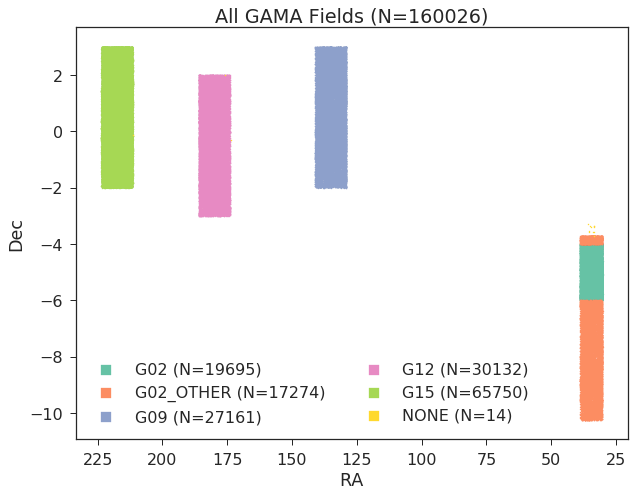

In [20]:
qa_radec_allgama(allgama, overwrite=overwrite_sample)

### Select galaxies with good redshifts and Legacy Survey photometry and K-corrections.

In [21]:
faintcut = 20 # [DECaLS r-band, extinction-corrected]

In [41]:
def gama_legacysurvey_sample(allgama, faintcut=20, overwrite=False):
    """
    Select galaxies with good redshifts and Legacy Survey photometry.
    """
    from astropy.table import join

    #truthdir = os.path.join(os.getenv('DESI_ROOT'), 'target', 'analysis', 'truth')
    
    def match_legacysurvey(allgama):
        """
        Read the GAMA/DR3 catalog matched to LegacySurvey/DR5.
        """
        matchdir  = '/project/projectdirs/desi/target/analysis/truth/dr7.1/matched' 
        gamafile  = os.path.join(matchdir, 'GAMA-DR3-SpecObj-match.fits')
        #gamafile = os.path.join(truthdir, 'dr5.0', 'trimmed', 'GAMA-DR3-SpecObj-trim.fits')
        cataid    = fitsio.read(gamafile, columns='CATAID', ext=1)

        lsfile    = os.path.join(matchdir, 'ls-dr7.1-GAMA-DR3-SpecObj-match.fits')
        #lsfile   = os.path.join(gamadir, 'decals-dr7.1-GAMA-DR3-SpecObj-match.fits')
        #lsfile   = os.path.join(truthdir, 'dr5.0', 'trimmed', 'decals-dr5.0-GAMA-DR3-SpecObj-trim.fits')
        ls        = Table(fitsio.read(lsfile, ext=1))
        
        ls.add_column(Column(name='CATAID', data=cataid))
        
        print('Read {} objects from {}'.format(len(ls), lsfile))
        '''
        kcorrfile = os.path.join(gamadir, 'decals-dr7.1-GAMA-DR3-SpecObj-match-kcorr.fits')
        kcorr     = Table(fitsio.read(kcorrfile, ext=1))
        kcorr.remove_column('Z') # we already have it
        print('Read {} objects from {}'.format(len(kcorr), kcorrfile))
    
        print('Adding Legacy Survey photometry and K-corrections for {} GAMA objects.'.format(len(allgama)))
        '''
        lsgama = join(allgama, ls, join_type='left', keys='CATAID')
        #lsgama = join(lsgama, kcorr, join_type='left', keys='CATAID')
        
        lsgama.rename_column('RA_1', 'RA_GAMA')
        lsgama.rename_column('DEC_1', 'DEC_GAMA')
        lsgama.rename_column('RA_2', 'RA')
        lsgama.rename_column('DEC_2', 'DEC')

        return lsgama
        
    
    # Read and match to the Legacy Survey photometry.
    alllsgama = match_legacysurvey(allgama)
    
    cut = ( (alllsgama['NQ'] >= 3) * (alllsgama['Z'] > 0.01) * (alllsgama['Z'] < 1) * 
           (alllsgama['FIELD'] != 'G02_OTHER') * (alllsgama['FIELD'] != 'NONE') *
           #(alllsgama['MASS'] > 0) * 
           #(alllsgama['HB_EW'] > 0) * (alllsgama['D4000N'] > 0) *
           (alllsgama['FLUX_R'] / alllsgama['MW_TRANSMISSION_R']) > 10**((22.5 - faintcut) / 2.5) )
    
    lsgama = alllsgama[cut]

    print('Selecting {} objects with NQ>=3, 0.01<z<1, and r<{:.1f} in the G02, G09, G12, and G15 fields.'.format(
        np.sum(cut), faintcut))
    
    if overwrite:
        print('Writing {} GAMA objects to {}'.format(len(lsgama), samplefile))
        #lsgama.write(samplefile, overwrite=overwrite)
        write_bintable(samplefile, lsgama, clobber=overwrite, extname='GAMA-DR3')
    
    return lsgama

In [43]:
lsgama = gama_legacysurvey_sample(allgama, faintcut=faintcut, overwrite=overwrite_sample)

Read 158871 objects from /project/projectdirs/desi/target/analysis/truth/dr7.1/matched/ls-dr7.1-GAMA-DR3-SpecObj-match.fits
Selecting 132487 objects with NQ>=3, 0.01<z<1, and r<20.0 in the G02, G09, G12, and G15 fields.
Writing 132487 GAMA objects to /global/cscratch1/sd/mjwilson/svdc-summer2018/bgs-gama-sample.fits


In [44]:
print(lsgama)

 CATAID        GAMA_NAME        IC_FLAG ... PMDEC_IVAR BRIGHTSTARINBLOB
                                        ...                            
------- ----------------------- ------- ... ---------- ----------------
   6802 GAMAJ113601.43+004315.3    4104 ...        0.0            False
   6806 GAMAJ113605.47+004221.3    4104 ...        0.0            False
   6808 GAMAJ113624.17+003932.1    4104 ...        0.0            False
   6810 GAMAJ113626.18+004814.0    4104 ...        0.0            False
   6813 GAMAJ113615.31+003840.3    4104 ...        0.0            False
   6820 GAMAJ113608.43+004721.4    4104 ...        0.0            False
   6826 GAMAJ113644.38+004232.5    4104 ...        0.0            False
   6830 GAMAJ113707.32+004221.9    4104 ...        0.0            False
   6835 GAMAJ113648.63+005020.6    4104 ...        0.0            False
   6837 GAMAJ113712.66+004723.9    4104 ...        0.0            False
    ...                     ...     ... ...        ...          

In [45]:
def qa_gama_sample(lsgama, faintcut=20, overwrite=False):
    """
    Visualize the magnitude and redshift distributions.
    """
    def get_rmag(cat):
        return 22.5 - 2.5 * np.log10(cat['FLUX_R'] / cat['MW_TRANSMISSION_R'])
        
    rmag = get_rmag(lsgama)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

    _colors = iter(sns.color_palette())
    for field in sorted(set(lsgama['FIELD'])):
        these = field == lsgama['FIELD']
        ax1.hist(lsgama['Z'][these], bins=50, range=(0, 1), label='{} (N={})'.format(field, np.sum(these)),
                 histtype='step', lw=2, color=next(_colors))
    ax1.set_xlabel('GAMA Redshift')
    ax1.set_ylabel('Number of Objects')
    #ax1.legend(loc='upper right', fontsize=14)
    
    _colors = iter(sns.color_palette())
    for field in sorted(set(lsgama['FIELD'])):
        these = field == lsgama['FIELD']
        ax2.hist(rmag[these], bins=50, range=(13, 20.5), label='{} (N={})'.format(field, np.sum(these)),
                 histtype='step', lw=2, color=next(_colors))
    ax2.set_xlabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax2.set_ylabel('Number of Objects')
    ax2.legend(loc='upper left', fontsize=12)
    ax2.axvline(x=faintcut, color='k', ls='--')
    
    ax3.scatter(lsgama['Z'], rmag, s=1, color='gray')
    ax3.set_xlabel('GAMA Redshift')
    ax3.set_ylabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax3.set_ylim(13, 20.5)
    ax3.axhline(y=faintcut, color='k', ls='--')
    
    fig.subplots_adjust(wspace=0.35)
    fig.tight_layout()
    
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-zhist.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/qaplots/qa-gama-zhist.png


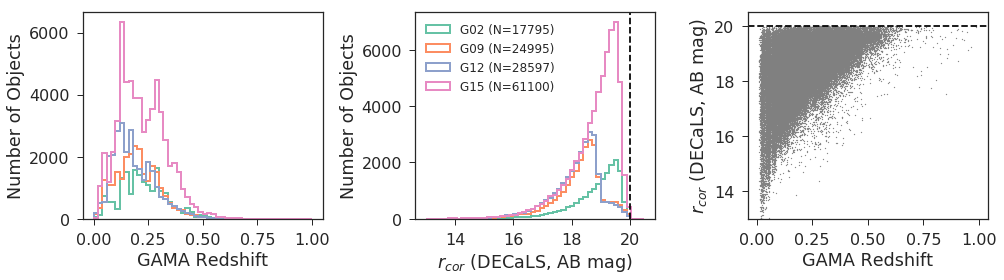

In [46]:
qa_gama_sample(lsgama, faintcut=faintcut, overwrite=overwrite_sample)

### Generate some additional spectroscopic QA plots.

In [47]:
def qa_gama_spec(lsgama, overwrite=False):

    good = (lsgama['HB_EW'] > 0) * (lsgama['D4000N'] > 0)
    ewhb = np.log10(lsgama['HB_EW'][good])
    d4000 = lsgama['D4000N'][good]
    
    fig, ax = plt.subplots()
    ax.scatter(d4000, ewhb, s=3)
    ax.set_xlim(0.6, 2.5)
    ax.set_ylim(-1, 2)
    ax.set_xlabel(r'$D_{n}(4000)$')
    ax.set_ylabel(r'$\log_{10}$ EW(H$\beta$) ($\AA$)')

    fig.tight_layout()
    
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-d4000-ewhb.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

In [48]:
def qa_colormag(lsgama, overwrite=False):
    Mr = lsgama['UGRIZ_ABSMAG_01'][:, 2]
    gr = lsgama['UGRIZ_ABSMAG_01'][:, 1] - Mr
    
    fig, ax = plt.subplots(figsize=(8, 5))
    hb = ax.hexbin(Mr, gr, mincnt=3, bins='log', gridsize=50, 
                   extent=(-14, -25, -0.2, 1.5), cmap='Blues_r')
    ax.set_xlim(-14, -25)
    ax.set_ylim(-0.2, 1.5)
    ax.set_xlabel(r'$M_{0.1r}$')
    ax.set_ylabel(r'$^{0.1}(g-r)$')
    cb = fig.colorbar(hb)
    cb.set_label(r'$\log_{10}$ (Number of Galaxies)')

    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-colormag.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

In [51]:
# qa_colormag(lsgama, overwrite=overwrite_sample)

Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/qaplots/qa-d4000-ewhb.png


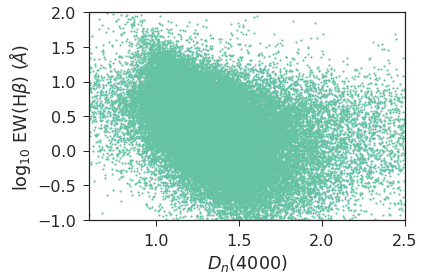

In [52]:
qa_gama_spec(lsgama, overwrite=overwrite_sample)

In [53]:
print('Done.')

Done.
